In [1]:
import crossref_commons.retrieval
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

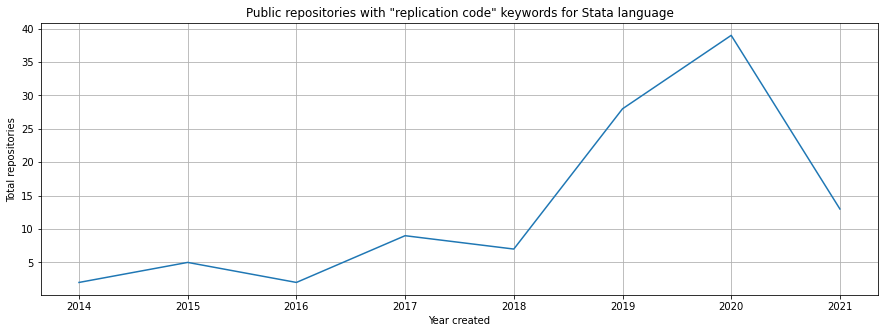

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-05-02 00:12:54: https://www.aeaweb.org/journals/aer/issues
2021-05-02 00:12:56: https://www.aeaweb.org/journals/aeri/issues
2021-05-02 00:12:57: https://www.aeaweb.org/journals/app/issues
2021-05-02 00:12:59: https://www.aeaweb.org/journals/pol/issues
2021-05-02 00:13:01: https://www.aeaweb.org/journals/mac/issues
2021-05-02 00:13:03: https://www.aeaweb.org/journals/mic/issues
2021-05-02 00:13:04: https://www.aeaweb.org/journals/jel/issues
2021-05-02 00:13:06: https://www.aeaweb.org/journals/jep/issues
2021-05-02 00:13:08: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

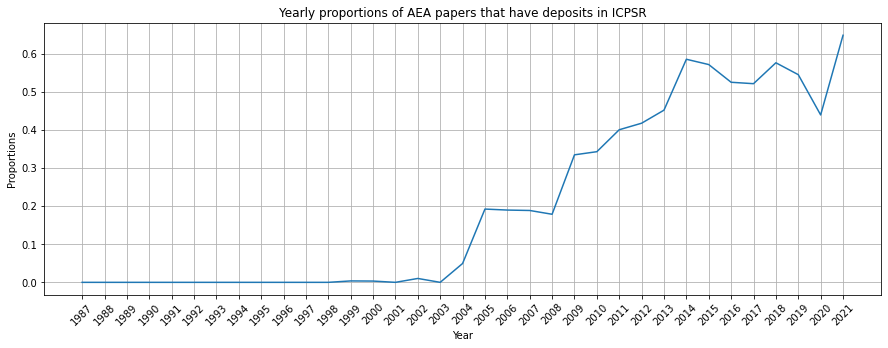

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [10]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review (#1)
- Journal of Economic Literature (#2)
- Journal of Economic Perspectives (#10)

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## 3. The Quarterly Journal of Economics

In [14]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-05-02 00:13:12: http://dx.doi.org/10.1093/qje/qjz024
2021-05-02 00:13:15: http://dx.doi.org/10.1162/0033553042476198
2021-05-02 00:13:17: http://dx.doi.org/10.1093/qje/qjr032
2021-05-02 00:13:20: http://dx.doi.org/10.1162/0033553041382201
2021-05-02 00:13:23: http://dx.doi.org/10.1093/qje/qjw009
2021-05-02 00:13:26: http://dx.doi.org/10.1162/003355304772839533
2021-05-02 00:13:28: http://dx.doi.org/10.1162/00335530360698469
2021-05-02 00:13:31: http://dx.doi.org/10.1093/qje/121.1.267
2021-05-02 00:13:33: http://dx.doi.org/10.1093/qje/qjz022
2021-05-02 00:13:36: http://dx.doi.org/10.1093/qje/qjx021
2021-05-02 00:13:39: http://dx.doi.org/10.1162/qjec.122.2.441
2021-05-02 00:13:43: http://dx.doi.org/10.1162/qjec.2009.124.4.1403
2021-05-02 00:13:45: http://dx.doi.org/10.1162/003355302753650355
2021-05-02 00:13:48: http://dx.doi.org/10.1162/0033553041502144
2021-05-02 00:13:50: http://dx.doi.org/10.1093/qje/qjz020
2021-05-02 00:13:53: http://dx.doi.org/10.1093/qje/qjt035
2021-05-02 00:

## 5. Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-05-02 00:20:24: http://dx.doi.org/10.1086/679497
2021-05-02 00:20:27: http://dx.doi.org/10.1086/697085
2021-05-02 00:20:29: http://dx.doi.org/10.1086/666589
2021-05-02 00:20:31: http://dx.doi.org/10.1086/693038
2021-05-02 00:20:33: http://dx.doi.org/10.1086/708857
2021-05-02 00:20:35: http://dx.doi.org/10.1086/653714
2021-05-02 00:20:38: http://dx.doi.org/10.1086/669681
2021-05-02 00:20:40: http://dx.doi.org/10.1086/704072
2021-05-02 00:20:42: http://dx.doi.org/10.1086/511283
2021-05-02 00:20:44: http://dx.doi.org/10.1086/426037
2021-05-02 00:20:46: http://dx.doi.org/10.1086/506334
2021-05-02 00:20:49: http://dx.doi.org/10.1086/655976
2021-05-02 00:20:51: http://dx.doi.org/10.1086/691702
2021-05-02 00:20:53: http://dx.doi.org/10.1086/701809
2021-05-02 00:20:55: http://dx.doi.org/10.1086/688849
2021-05-02 00:20:57: http://dx.doi.org/10.1086/686748
2021-05-02 00:20:59: http://dx.doi.org/10.1086/712761
2021-05-02 00:21:01: http://dx.doi.org/10.1086/675238
2021-05-02 00:21:03: http://

## 6. Journal of Economic Growth 

In [16]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-05-02 00:41:35: http://dx.doi.org/10.1007/s10887-009-9040-3
2021-05-02 00:41:37: http://dx.doi.org/10.1007/s10887-006-9007-6
2021-05-02 00:41:38: http://dx.doi.org/10.1007/s10887-005-1669-y
2021-05-02 00:41:40: http://dx.doi.org/10.1007/s10887-016-9139-2
2021-05-02 00:41:41: http://dx.doi.org/10.1007/s10887-013-9099-8
2021-05-02 00:41:44: http://dx.doi.org/10.1007/s10887-014-9102-z
2021-05-02 00:41:45: http://dx.doi.org/10.1007/s10887-005-1112-4
2021-05-02 00:41:47: http://dx.doi.org/10.1007/s10887-019-09163-5
2021-05-02 00:41:49: http://dx.doi.org/10.1007/s10887-018-9159-1
2021-05-02 00:41:50: http://dx.doi.org/10.1007/s10887-019-09169-z
2021-05-02 00:41:52: http://dx.doi.org/10.1007/s10887-008-9032-8
2021-05-02 00:41:54: http://dx.doi.org/10.1007/s10887-016-9127-6
2021-05-02 00:41:56: http://dx.doi.org/10.1007/s10887-006-9000-0
2021-05-02 00:41:57: http://dx.doi.org/10.1007/s10887-015-9111-6
2021-05-02 00:42:00: http://dx.doi.org/10.1007/s10887-009-9043-0
2021-05-02 00:42:01: ht

## 7. Review of Financial Studies

In [17]:
path = 'data/crossref/s-oup-rfinst'
rfinst = os.listdir(path)

def has_replication(url):

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            print(res)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplementary = content.find('h2', {'id': 'supplementary-data'})
            return supplementary != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, rfinst, 'the-review-of-financial-studies')

2021-05-02 00:47:12: http://dx.doi.org/10.1093/rfs/hhy046
<Response [200]>
2021-05-02 00:47:13: http://dx.doi.org/10.1093/rfs/hhv008
<Response [200]>
2021-05-02 00:47:14: http://dx.doi.org/10.1093/rfs/hhu038
<Response [200]>
2021-05-02 00:47:15: http://dx.doi.org/10.1093/rfs/hhu039
<Response [200]>
2021-05-02 00:47:16: http://dx.doi.org/10.1093/rfs/hhz085
<Response [200]>
2021-05-02 00:47:17: http://dx.doi.org/10.1093/rfs/hhy095
<Response [200]>
2021-05-02 00:47:18: http://dx.doi.org/10.1093/rfs/hht131
<Response [200]>
2021-05-02 00:47:19: http://dx.doi.org/10.1093/rfs/hhu024
<Response [200]>
2021-05-02 00:47:20: http://dx.doi.org/10.1093/rfs/hht034
<Response [200]>
2021-05-02 00:47:20: http://dx.doi.org/10.1093/rfs/hhs068
<Response [200]>
2021-05-02 00:47:21: http://dx.doi.org/10.1093/rfs/hhy100
<Response [200]>
2021-05-02 00:47:22: http://dx.doi.org/10.1093/rfs/hht003
<Response [200]>
2021-05-02 00:47:23: http://dx.doi.org/10.1093/rfs/hhx134
<Response [200]>
2021-05-02 00:47:23: http

## 8. Econometrica 

In [18]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-05-02 00:52:58: http://dx.doi.org/10.3982/ecta13918
2021-05-02 00:53:01: http://dx.doi.org/10.3982/ecta16481
2021-05-02 00:53:04: http://dx.doi.org/10.3982/ecta16047
2021-05-02 00:53:07: http://dx.doi.org/10.3982/ecta17288
2021-05-02 00:53:09: http://dx.doi.org/10.3982/ecta18788
2021-05-02 00:53:12: http://dx.doi.org/10.3982/ecta17477
2021-05-02 00:53:15: http://dx.doi.org/10.3982/ecta16646
2021-05-02 00:53:18: http://dx.doi.org/10.3982/ecta15897
2021-05-02 00:53:21: http://dx.doi.org/10.3982/ecta9508
2021-05-02 00:53:21: http://dx.doi.org/10.3982/ecta14370
2021-05-02 00:53:24: http://dx.doi.org/10.3982/ecta12675
2021-05-02 00:53:27: http://dx.doi.org/10.3982/ecta10762
2021-05-02 00:53:30: http://dx.doi.org/10.3982/ecta15530
2021-05-02 00:53:32: http://dx.doi.org/10.3982/ecta16566
2021-05-02 00:53:35: http://dx.doi.org/10.3982/ecta10557
2021-05-02 00:53:37: http://dx.doi.org/10.3982/ecta16557
2021-05-02 00:53:39: http://dx.doi.org/10.3982/ecta17056
2021-05-02 00:53:41: http://dx.d

## 9. Journal of Finance

In [19]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    status_code = None
    while status_code not in [200, 404]:
        try:
            url = 'https://afajof.org/supplements/'
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass        
    content = BeautifulSoup(res.content, features='html.parser')
    div = content.find('div', {'class': 'site-content-contain'})
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)